<a href="https://colab.research.google.com/github/OscarChang46/de-identify-sensitive-data-for-cybersecurity-use-cases-e.g.-PII-and-PHI-data-in-unstructured-text-an/blob/main/conll_2003baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
! pip install transformers

     |████████████████████████████████| 2.9 MB 12.6 MB/s 
     |████████████████████████████████| 895 kB 36.9 MB/s 
     |████████████████████████████████| 596 kB 46.8 MB/s 
     |████████████████████████████████| 56 kB 4.7 MB/s 
     |████████████████████████████████| 3.3 MB 39.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [3]:
import numpy as np
import pandas as pd

from transformers import AutoTokenizer

from tqdm import tqdm
import tensorflow as tf

import matplotlib.pyplot as plt

In [4]:
def load_sentences(filepath):

    final = []
    sentences = []

    with open(filepath, 'r') as f:
        
        for line in f.readlines():
            
            if (line == ('-DOCSTART- -X- -X- O\n') or line == '\n'):
                if len(sentences) > 0:
                    final.append(sentences)
                    sentences = []
            else:
                l = line.split(' ')
                sentences.append((l[0], l[3].strip('\n')))
    
    return final

In [5]:
base_path = './drive/MyDrive/berkeley/capstone/demo/conll2003/'

train_samples = load_sentences(base_path + 'train.txt')
test_samples = load_sentences(base_path + 'test.txt')
valid_samples = load_sentences(base_path + 'valid.txt')

samples = train_samples + test_samples

schema = ['_'] + sorted({tag for sentence in samples 
                             for _, tag in sentence})

# Model

In [6]:
from transformers import AutoConfig, TFAutoModelForTokenClassification

MODEL_NAME = 'bert-base-cased' 

config = AutoConfig.from_pretrained(MODEL_NAME, num_labels=len(schema))
model = TFAutoModelForTokenClassification.from_pretrained(MODEL_NAME, 
                                                          config=config)
model.summary()

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/502M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForTokenClassification.

Some layers of TFBertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_token_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  107719680 
_________________________________________________________________
dropout_37 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  7690      
Total params: 107,727,370
Trainable params: 107,727,370
Non-trainable params: 0
_________________________________________________________________


In [7]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_sample(sample):
    seq = [
               (subtoken, tag)
               for token, tag in sample
               for subtoken in tokenizer(token)['input_ids'][1:-1]
           ]
    return [(3, 'O')] + seq + [(4, 'O')]

def preprocess(samples):
    tag_index = {tag: i for i, tag in enumerate(schema)}
    tokenized_samples = list(tqdm(map(tokenize_sample, samples)))
    max_len = max(map(len, tokenized_samples))
    X = np.zeros((len(samples), max_len), dtype=np.int32)
    y = np.zeros((len(samples), max_len), dtype=np.int32)
    for i, sentence in enumerate(tokenized_samples):
        for j, (subtoken_id, tag) in enumerate(sentence):
            X[i, j] = subtoken_id
            y[i,j] = tag_index[tag]
    return X, y

X_train, y_train = preprocess(train_samples)
X_test, y_test = preprocess(test_samples)
X_valid, y_valid = preprocess(valid_samples)

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

14041it [00:15, 913.02it/s]
3453it [00:03, 979.34it/s] 
3250it [00:03, 832.84it/s]


In [8]:
EPOCHS=5
BATCH_SIZE=8

optimizer = tf.keras.optimizers.Adam(lr=0.000001)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics='accuracy')
history = model.fit(tf.constant(X_train), tf.constant(y_train),
                    validation_data=(X_test, y_test), 
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/5
1756/1756 [==============================] - 1137s 635ms/step - loss: 0.1566 - accuracy: 0.9626 - val_loss: 0.0591 - val_accuracy: 0.9837
Epoch 2/5
1756/1756 [==============================] - 1112s 633ms/step - loss: 0.0432 - accuracy: 0.9879 - val_loss: 0.0345 - val_accuracy: 0.9897
Epoch 3/5
1756/1756 [==============================] - 1113s 634ms/step - loss: 0.0278 - accuracy: 0.9919 - val_loss: 0.0271 - val_accuracy: 0.9919
Epoch 4/5
1756/1756 [==============================] - 1112s 633ms/step - loss: 0.0207 - accuracy: 0.9939 - val_loss: 0.0222 - val_accuracy: 0.9936
Epoch 5/5
1756/1756 [==============================] - 1112s 633ms/step - loss: 0.0159 - accuracy: 0.9954 - val_loss: 0.0204 - val_accuracy: 0.9943


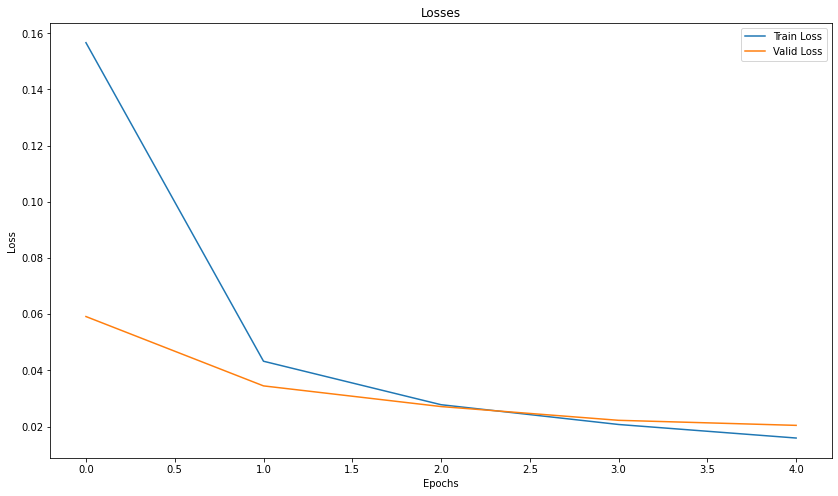

In [9]:
plt.figure(figsize=(14,8))
plt.title('Losses')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Valid Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()